# CAPSTONE PROJECT - CLUSTERING

**Description**

**Context:**
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

**Objective:** To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

**Dataset:**  ALLLife bank

**Data Description:** Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.


# IMPORT NECESSARY PACKAGES

In [4]:
# Import warnings package and use it to suppress non-fatal warnings such as Depreciation
# and FutureWarnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score

In [6]:
print(np.__version__) # 1.20.2
print(sklearn.__version__) # 0.24.1
print(pd.__version__) # 1.2.4
print(sns.__version__) # 0.11.1

1.19.5
0.23.2
1.1.5
0.11.1


# DATA STRUCTURE

In [7]:
# Loading the data using pandas
# Set Sl_No as the index column
df = pd.read_excel("Credit Card Customer Data.xlsx", index_col="Sl_No")
# Making copy of the original data
df_original = df.copy()

# Viewing the first 7 rows of the data
df.head(7)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
1,87073,100000,2,1,1,0
2,38414,50000,3,0,10,9
3,17341,50000,7,1,3,4
4,40496,30000,5,1,1,4
5,47437,100000,6,0,12,3
6,58634,20000,3,0,1,8
7,48370,100000,5,0,11,2


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 1 to 660
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 36.1 KB


In [9]:
df.isnull().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

**Observations:** 
- There are 660 rows and 6 columns in the dataset. That is after setting Sl_No column as the index.
- All columns are numeric of int64 datatype.
- (On missing values) Based on output of pd.DataFrame.isnull.sum() function above and the data types outputed by df.info() we can confidently conclude that there are no missing values in the dataset.
- Customer Key column is an identify and such may not be used in the clustering (segmentation of the data).

**Remark (Variables):** 

*Customer Key* and *Sl_No* are discrete variables; *Avg_Credit_Limit* is a discrete variable but can take continous values, of course; *Total_Credit_Cards*,	*Total_visits_bank* ,*Total_visits_online* and *Total_calls_made* are discrete variables but can also be viewed as ordinal variables.

In [10]:
df.describe()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


**Observations:**



##### Are there duplicates based on the Customer Key

In [11]:
# How many dumplicated are they?
df.duplicated(subset=["Customer Key"],keep="first").value_counts() # They are 5

False    655
True       5
dtype: int64

In [12]:
# Determining dumplicated rows
df_duplicated = df[df.duplicated(subset=["Customer Key"], keep=False)].sort_values(by=["Customer Key"])
df_duplicated

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
49,37252,6000,4,0,2,8
433,37252,59000,6,2,1,2
5,47437,100000,6,0,12,3
333,47437,17000,7,3,1,0
412,50706,44000,4,5,0,2
542,50706,60000,7,5,2,2
392,96929,13000,4,5,0,0
399,96929,67000,6,2,2,2
105,97935,17000,2,1,2,10


**Expectation:** We expect that there are no duplicates in the data based on Customer Key column because it is an identifier (a primary key).

**Observation:**  On filtering duplicates, we realized that there exists 5 pairs of duplicates based on the Customer Key column. Looking at the rest of the columns, we realize that the duplication does not apply to the other columns

**Possible reasons:**
1. AllLife Bank created a new record when it was supposed to update the already existing record.

2. The two accounts are possibly just joint accounts so that the Customer Key is shared and the distinction made by using both Customer Key and Sl_No columns (A composite key).

2. Worst scenario is a case of security breach where this case can be tagged as identity theft.

**What do we do:** There are two ways we can deal with this situation - randomly drop the duplicates (we will drop only 5 rows out of 660) or keep them because the feature values are different. We will pursue the latter with the reasoning given.

In [13]:
# We can now drop the identify (Customer Key) and scale the data
df.drop(["Customer Key"], axis=1, inplace=True)
df_original2 = df.copy()

In [14]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,
1,100000,2,1,1,0
2,50000,3,0,10,9
3,50000,7,1,3,4
4,30000,5,1,1,4
5,100000,6,0,12,3


# EXPLORATORY DATA ANALYSIS

1      8.939394
2      9.696970
3      8.030303
4     22.878788
5     11.212121
6     17.727273
7     15.303030
8      1.666667
9      1.666667
10     2.878788
Name: Total_Credit_Cards, dtype: float64


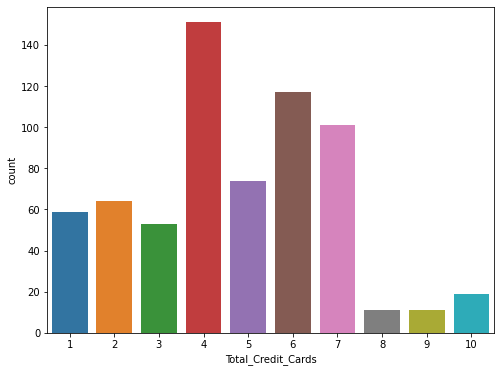

0    15.151515
1    16.969697
2    23.939394
3    15.151515
4    13.939394
5    14.848485
Name: Total_visits_bank, dtype: float64


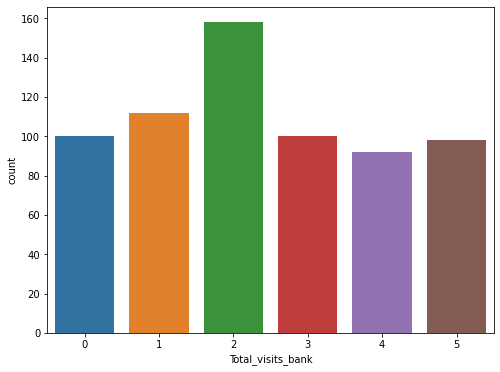

0     21.818182
1     16.515152
2     28.636364
3      6.666667
4     10.454545
5      8.181818
6      0.151515
7      1.060606
8      0.909091
9      0.606061
10     0.909091
11     0.757576
12     0.909091
13     0.757576
14     0.151515
15     1.515152
Name: Total_visits_online, dtype: float64


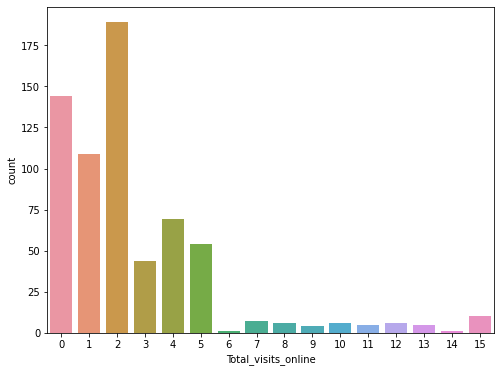

0     14.696970
1     13.636364
2     13.787879
3     12.575758
4     16.363636
5      4.393939
6      5.909091
7      5.303030
8      4.545455
9      4.848485
10     3.939394
Name: Total_calls_made, dtype: float64


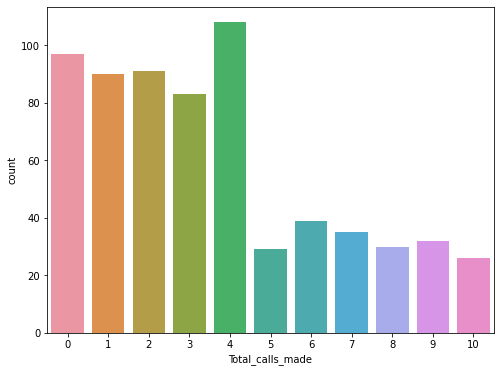

In [15]:
# Unique values of each categories
# Viewing these columns as ordinal columns, we will treat them as discrete later
all_categories = ["Total_Credit_Cards",
                  "Total_visits_bank",
                  "Total_visits_online",
                  "Total_calls_made"] 
for category in all_categories:
    print(df[category].value_counts(normalize=True, sort=False)*100)
    plt.figure(figsize=(8,6))
    sns.countplot(df[category])
    plt.show()

**Observations:**

- Total_Credit_Cards : Majority of customers possess 4,5,6,7 credit cards (67 of the customers). Only 8 percent of the customers have one credit cards. This observation is a surprising fact.
- Total_visits_bank : Majority of customers made 2 visits to the bank.
- Total_visits_online: Approximately 80% of the customers made between 1 and 5 visits on the online website of the bank. 21.8% made no visits to the online plaform. Consequently, approximately 9% of the customers made more than 5 visits.
- Total_calls_made: Approximately 56% of the customers made between 1 and 4 calls while 14.7% made no calls to the bank at all. The rest ~29% made 5 calls and more.

In [16]:
# Function to plot histogram and boxplot for numerical variables as we study the 
# central tendency and dispersion for such values
def histogram_boxplot(feature, figsize=(10,8), bins = None):
    """ 
    Boxplot and histogram combined with shared axis
    feature: 1-d feature array
    figsize: size of fig (default (10,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='red') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=False, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='g', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

Avg_Credit_Limit ,Skew 2.2


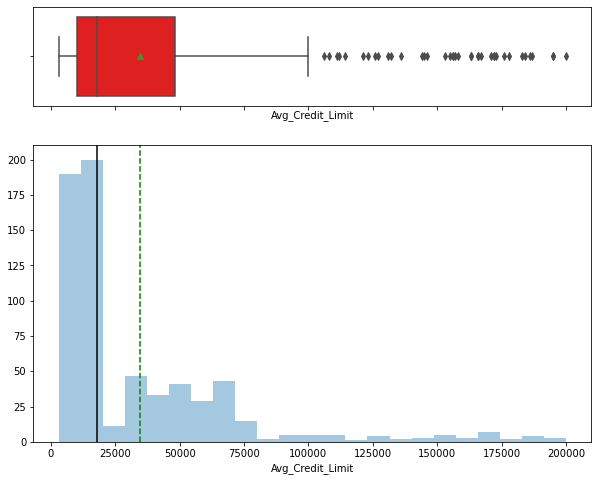

Total_Credit_Cards ,Skew 0.14


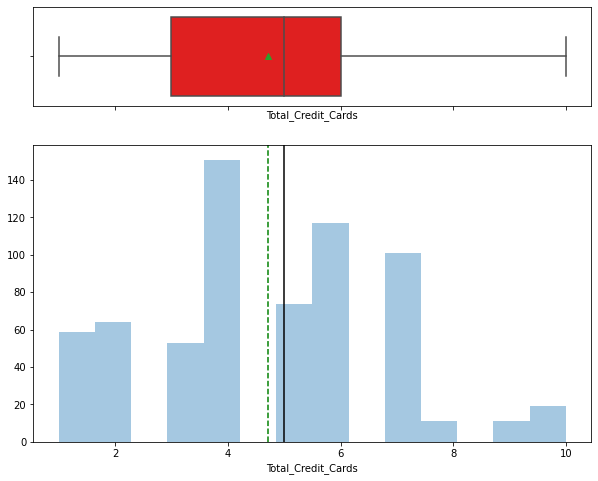

Total_visits_bank ,Skew 0.14


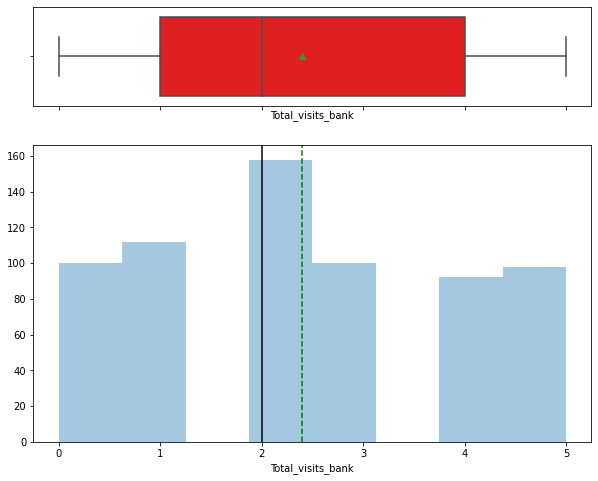

Total_visits_online ,Skew 2.23


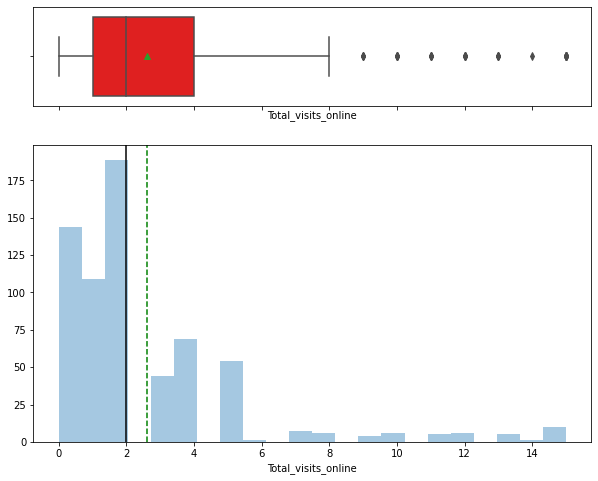

Total_calls_made ,Skew 0.66


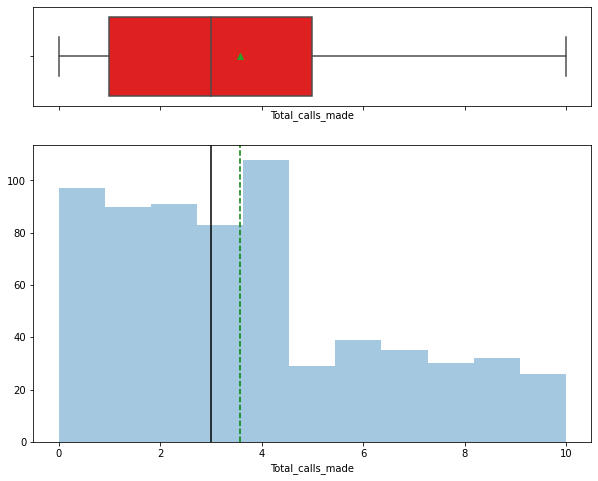

In [17]:
for col in df.columns:
    print(col,",Skew", round(df[col].skew(),2))
    histogram_boxplot(feature=df[col])
    plt.show()

**Observations (Outliers and skewness):**

- Avg_Credit_Limit - has upper outliers and right skewed.
- Total_Credit_Cards - no outliers and not skewed (normally distributed).
- Total_visits_bank - no outliers and not skewed (normall distributed).
- Total_visits_online - has upper outliers and right skewed.
- Total_calls_made - no outliers and slightly right skewed.

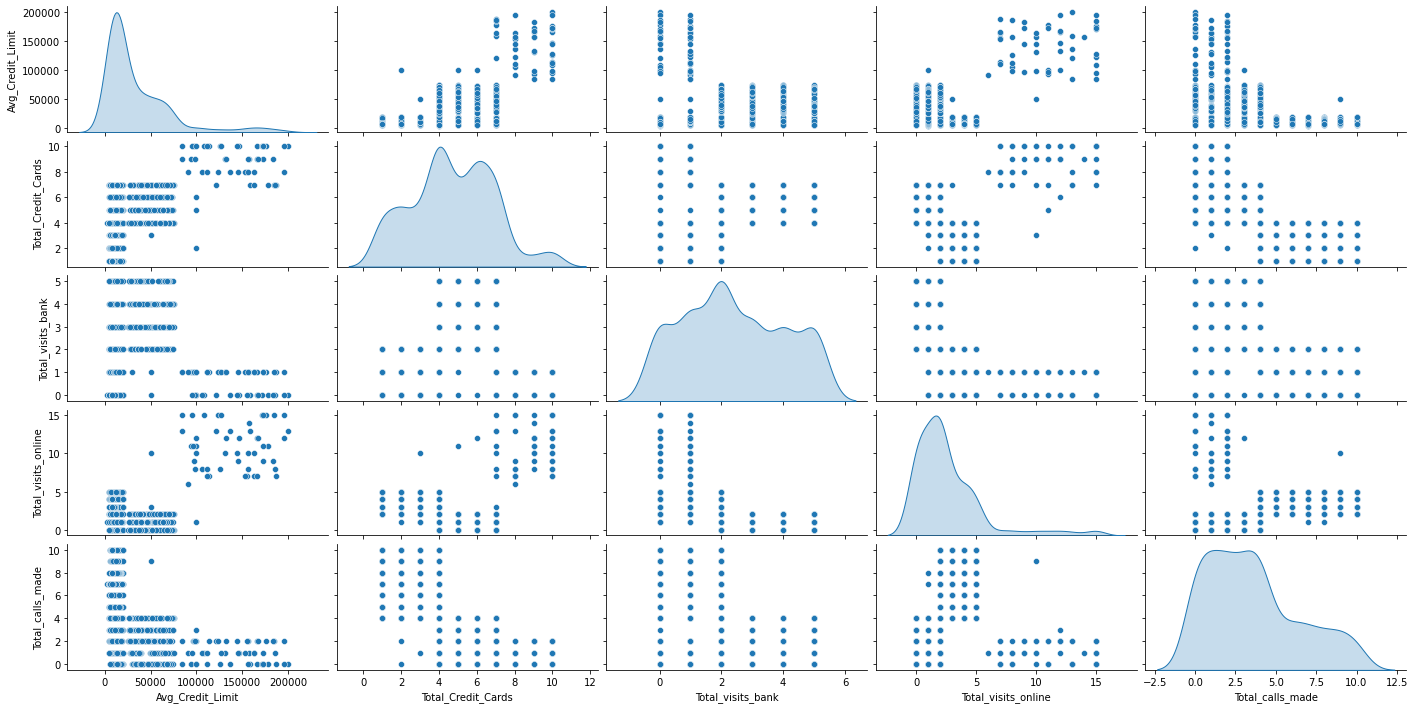

In [18]:
#importing seaborn for statistical plots
sns.pairplot(df[df.columns], height=2,aspect=2 , diag_kind='kde')

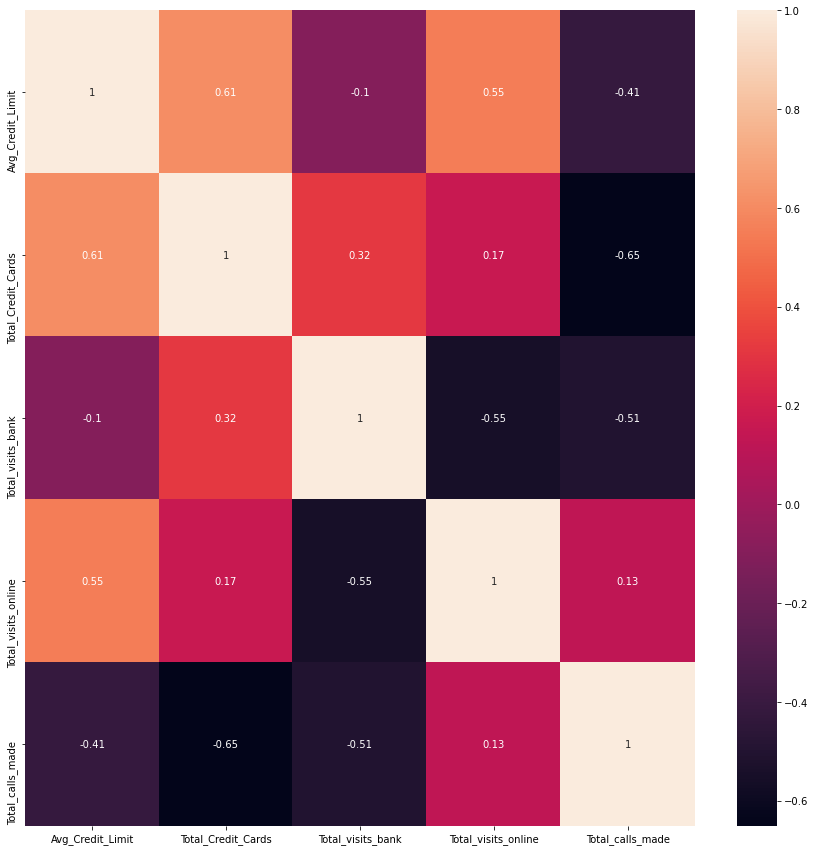

In [19]:
plt.figure(figsize=(15,15))
df_corr = df[df.columns].corr()
sns.heatmap(df_corr, annot=True);

In [23]:
df.to_csv("data_example_2.csv", index=False)

# DATA PROCESSING AND FEATURE ENGINEERING

In [20]:
# Scale the data by standardization - The result is column with mean 0
# and standard deviation=1 
df_scaled = df.apply(zscore)
df_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,
1,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
2,0.410293,-0.787585,-1.473731,2.520519,1.891859
3,0.410293,1.058973,-0.860451,0.134290,0.145528
4,-0.121665,0.135694,-0.860451,-0.547490,0.145528
5,1.740187,0.597334,-1.473731,3.202298,-0.203739


# MODEL BUILDING

## 1. K-MEAN CLUSTERING

Number of clusters:  2 Silhouette score:  0.41842496663215445
Number of clusters:  3 Silhouette score:  0.5157182558881063
Number of clusters:  4 Silhouette score:  0.3556670619372605
Number of clusters:  5 Silhouette score:  0.2717470361089752
Number of clusters:  6 Silhouette score:  0.25545029453623114
Number of clusters:  7 Silhouette score:  0.248175083050816
Number of clusters:  8 Silhouette score:  0.22723551565436467
Number of clusters:  9 Silhouette score:  0.22798672324527944
Number of clusters:  10 Silhouette score:  0.2101923844444077
Number of clusters:  11 Silhouette score:  0.21709523684603163
Number of clusters:  12 Silhouette score:  0.2053609113327048
Number of clusters:  13 Silhouette score:  0.20910939425565023
Number of clusters:  14 Silhouette score:  0.21972092420992037


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

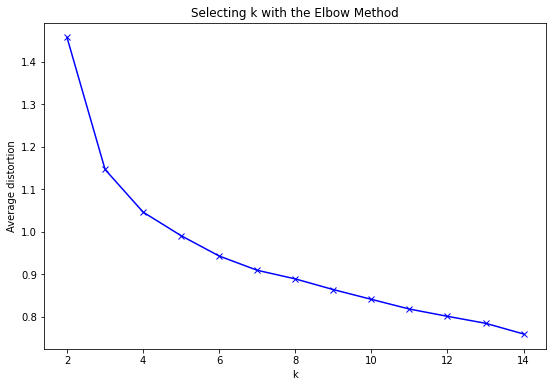

In [21]:
#Finding optimal no. of clusters using elbow plot
clusters=range(2,15)
meanDistortions=[]

for k in clusters:
    # Fit k-means with k clusters
    model=KMeans(n_clusters=k)
    model.fit(df_scaled)
    # Make predictions
    predictions=model.predict(df_scaled)
    # Silhouette Score
    ss = silhouette_score(df_scaled, predictions, metric='euclidean')
    print("Number of clusters: ",k,"Silhouette score: ", ss)
    meanDistortions.append(sum(np.min(cdist(df_scaled,\
                                            model.cluster_centers_, 'euclidean'), axis=1))\
                           / df_scaled.shape[0])

plt.figure(figsize=(9,6))
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

**Observation:** There seems to be an elbow at k=3. Silhoutte score also justifies the choice of k=3 as the number of clusters. We will also consider k=2 and k=4 clusters.

In [22]:
# Let us first start with K = 3
model3=KMeans(n_clusters=3)
model3.fit(df_scaled)
predictions3=model3.predict(df_scaled)

#Append the prediction 
df_original2["clusters3"] = predictions3
df_scaled["clusters3"] = predictions3
df_original2.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,clusters3
Sl_No,,,,,,
1,100000,2,1,1,0,1
2,50000,3,0,10,9,2
3,50000,7,1,3,4,1
4,30000,5,1,1,4,1
5,100000,6,0,12,3,0
6,20000,3,0,1,8,2
7,100000,5,0,11,2,0
8,15000,3,0,1,1,2
9,5000,2,0,2,2,2


In [20]:
df_clusters3 = df_original2.groupby(['clusters3']).mean()
df_clusters3

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
clusters3,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000
1,12174.107143,2.410714,0.933036,3.553571,6.870536
2,141040.000000,8.740000,0.600000,10.900000,1.080000


In [21]:
df_clusters3_count = df_original2.groupby(['clusters3']).count()
df_clusters3_count

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
clusters3,,,,,
0,386,386,386,386,386
1,224,224,224,224,224
2,50,50,50,50,50


**Observations and insights:**

- Clustering seems to clearly segment the market. Cluster 2 has the hight credit limit, followed by 0 then 1. It can also be seen that persons who prefer online interaction with the bank posses more credit cards and have high credit limits whereas the customers who prefer in-person interactions have least number of credit cards amd average credit limit.

- The box plot below clearly shows that clustering actually segment the market.
    

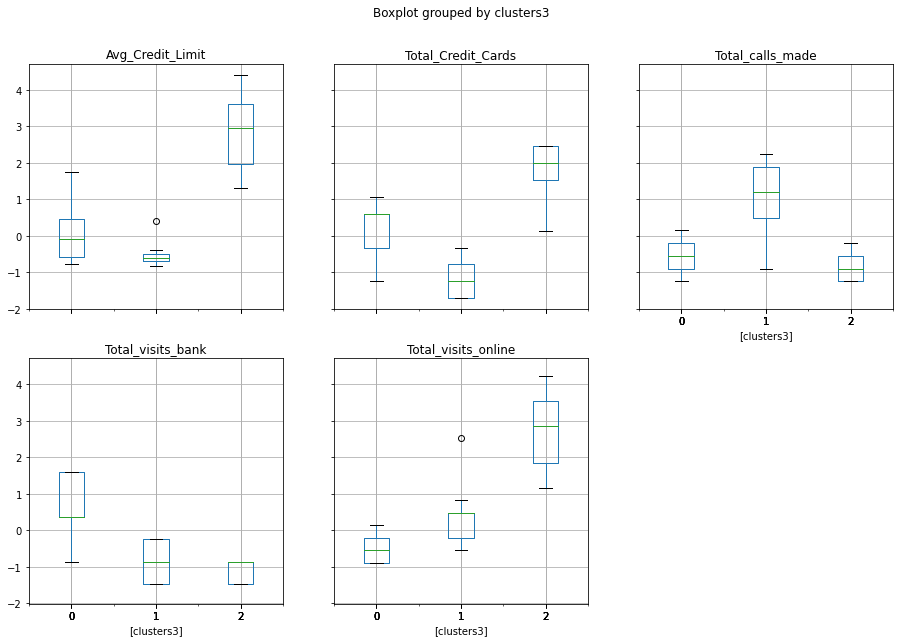

In [22]:
df_scaled.boxplot(by='clusters3', layout = (2,3),figsize=(15,10));

In [23]:
df_original2.drop(["clusters3"], axis=1, inplace=True)
df_scaled.drop(["clusters3"], axis=1, inplace=True)

In [24]:
# Let us first start with K = 2
model2=KMeans(n_clusters=2)
model2.fit(df_scaled)
predictions2=model2.predict(df_scaled)

In [26]:
#Append the prediction 
df_original2["clusters2"] = predictions2
df_scaled["clusters2"] = predictions2
df_original2.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,clusters2
Sl_No,,,,,,
1,100000,2,1,1,0,0
2,50000,3,0,10,9,1
3,50000,7,1,3,4,0
4,30000,5,1,1,4,0
5,100000,6,0,12,3,0
6,20000,3,0,1,8,1
7,100000,5,0,11,2,0
8,15000,3,0,1,1,1
9,5000,2,0,2,2,1


In [36]:
df_clusters2_mean = df_original2.groupby(['clusters2']).mean()
df_clusters2_mean

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
clusters2,,,,,
0,46082.568807,5.885321,3.158257,2.119266,1.894495
1,12174.107143,2.410714,0.933036,3.553571,6.870536


In [37]:
df_clusters2_count = df_original2.groupby(['clusters2']).count()
df_clusters2_count

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
clusters2,,,,,
0,436,436,436,436,436
1,224,224,224,224,224


**Observation and insight**
- With k=2, the first cluster have high average credit limit, high number of credit cards, more in-persons visits to the bank and least calls made. The second cluster has low average credit limit, low number of credit cards, least physical bank visits, more online visits and more phone calls.
- The box plot below justifies the clustering.

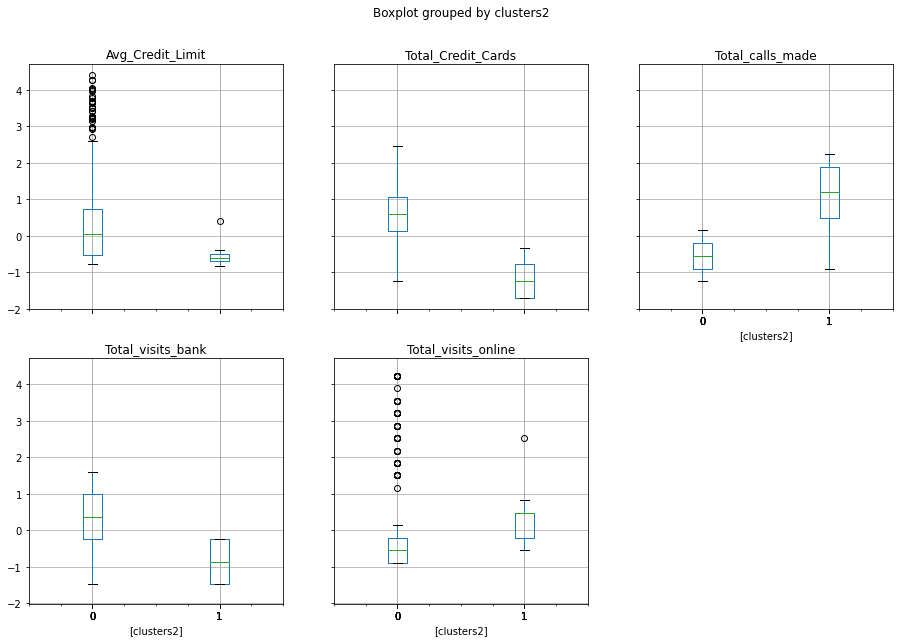

In [38]:
df_scaled.boxplot(by='clusters2', layout = (2,3),figsize=(15,10));

In [39]:
df_original2.drop(["clusters2"], axis=1, inplace=True)
df_scaled.drop(["clusters2"], axis=1, inplace=True)

In [40]:
# Let us first start with K = 4
model4=KMeans(n_clusters=4)
model4.fit(df_scaled)
predictions4=model4.predict(df_scaled)

#Append the prediction 
df_original2["clusters4"] = predictions4
df_scaled["clusters4"] = predictions4
df_original2.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,clusters4
Sl_No,,,,,,
1,100000,2,1,1,0,3
2,50000,3,0,10,9,0
3,50000,7,1,3,4,3
4,30000,5,1,1,4,3
5,100000,6,0,12,3,2
6,20000,3,0,1,8,0
7,100000,5,0,11,2,2
8,15000,3,0,1,1,3
9,5000,2,0,2,2,0


In [41]:
df_clusters4 = df_original2.groupby(['clusters4']).mean()
df_clusters4

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
clusters4,,,,,
0,12167.420814,2.393665,0.927602,3.574661,6.923077
1,31226.315789,5.478947,4.515789,1.010526,1.936842
2,141040.000000,8.740000,0.600000,10.900000,1.080000
3,35904.522613,5.522613,2.477387,0.969849,2.075377


In [42]:
df_clusters4_count = df_original2.groupby(['clusters4']).count()
df_clusters4_count

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
clusters4,,,,,
0,221,221,221,221,221
1,190,190,190,190,190
2,50,50,50,50,50
3,199,199,199,199,199


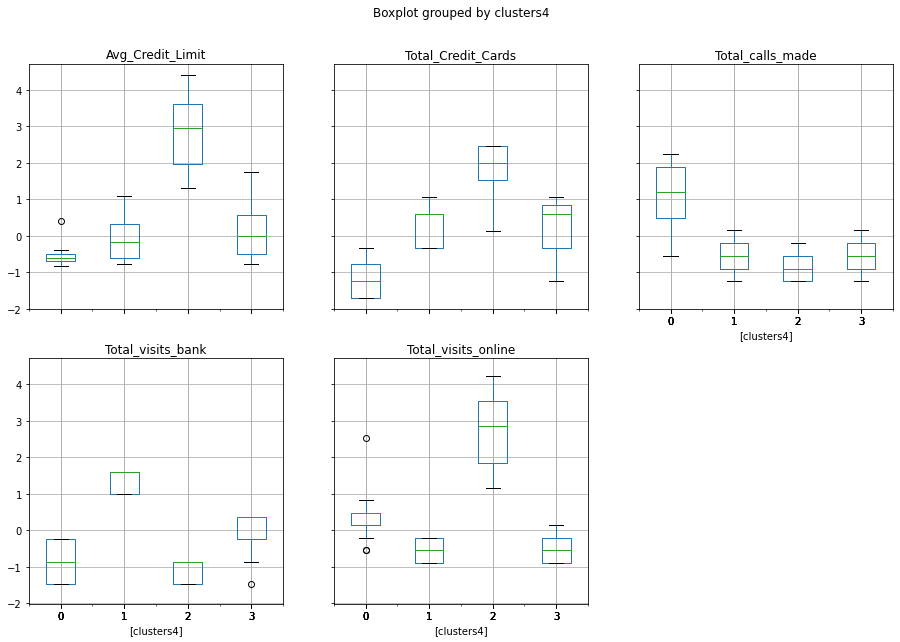

In [43]:
df_scaled.boxplot(by='clusters4', layout = (2,3),figsize=(15,10));

In [44]:
df_original2.drop(["clusters4"], axis=1, inplace=True)
df_scaled.drop(["clusters4"], axis=1, inplace=True)

**Observation:**

- The clustering done with k=4 is justfiable just like in the case of k=2 and k=3. 
- The boxplot however shows that segmentation differentiate cluster 1 and 2 using the number of bank visits MAINLY but the two clusters are not clearly differentiable with other features. This can be used as a justification to choose k=3.

## 2. HIERARCHICAL CLUSTERING

In [57]:
# Fiting Hierarchical Agglomorative clustering with three clusters
model3_hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')
model3_hc.fit(df_scaled)

df_original2['clusters3_hc'] = model3_hc.labels_
df_scaled['clusters3_hc'] = model3_hc.labels_
df_original2.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,clusters4_hc,clusters3_hc
Sl_No,,,,,,,
1,100000,2,1,1,0,3,0
2,50000,3,0,10,9,0,2
3,50000,7,1,3,4,2,0
4,30000,5,1,1,4,2,0
5,100000,6,0,12,3,1,1
6,20000,3,0,1,8,0,2
7,100000,5,0,11,2,1,1
8,15000,3,0,1,1,0,2
9,5000,2,0,2,2,0,2


In [58]:
df_clusters3_hc = df_original2.groupby(['clusters3_hc']).mean()
df_clusters3_hc

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,clusters4_hc
clusters3_hc,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,2.002584
1,141040.000000,8.740000,0.600000,10.900000,1.080000,1.000000
2,12197.309417,2.403587,0.928251,3.560538,6.883408,0.000000


In [59]:
df_clusters3_hc_count = df_original2.groupby(['clusters3_hc']).count()
df_clusters3_hc_count

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,clusters4_hc
clusters3_hc,,,,,,
0,387,387,387,387,387,387
1,50,50,50,50,50,50
2,223,223,223,223,223,223


**Observations:**
- Hierarchical Agllomorative clustering and K-Means clustering with k=3 obtained almost the same clusters as shown by the averages on df_clusters3_hc and df_clusters3. The same explanation follows.

In [24]:
# cophenet index is a measure of the correlation between the distance 
# of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(df_scaled, metric='euclidean', method='centroid')
c, coph_dists = cophenet(Z , pdist(df_scaled))
c

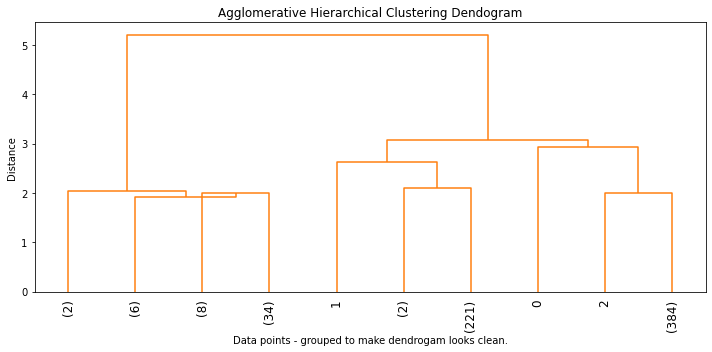

In [25]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('Data points - grouped to make dendrogam looks clean.')
plt.ylabel('Distance')
dendrogram(Z, p=10, truncate_mode='lastp', leaf_rotation=90.,color_threshold = 40, leaf_font_size=12.)
plt.tight_layout()
plt.show()

**Observation (Dendogram):** With this dendogram we can easily justify the distibution of customers based on any chice of the clusters. A peculiar example is the choice of k=4. With this choice, it is clear that one of the clusters will have one element. The same result is shown below.

<AxesSubplot:xlabel='Total_calls_made', ylabel='Total_visits_online'>

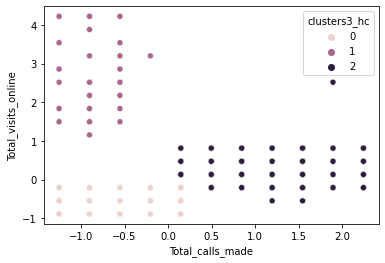

In [62]:
sns.scatterplot(df_scaled.Total_calls_made, df_scaled.Total_visits_online, hue=df_scaled.clusters3_hc)

In [63]:
df_original2.drop(["clusters3_hc"], axis=1, inplace=True)
df_scaled.drop(["clusters3_hc"], axis=1, inplace=True)

In [51]:
model4_hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='average')
model4_hc.fit(df_scaled)

df_original2['clusters4_hc'] = model4_hc.labels_
df_scaled['clusters4_hc'] = model4_hc.labels_
df_original2.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,clusters4_hc
Sl_No,,,,,,
1,100000,2,1,1,0,3
2,50000,3,0,10,9,0
3,50000,7,1,3,4,2
4,30000,5,1,1,4,2
5,100000,6,0,12,3,1
6,20000,3,0,1,8,0
7,100000,5,0,11,2,1
8,15000,3,0,1,1,0
9,5000,2,0,2,2,0


In [52]:
df_clusters4_hc = df_original2.groupby(['clusters4_hc']).mean()
df_clusters4_hc

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
clusters4_hc,,,,,
0,12197.309417,2.403587,0.928251,3.560538,6.883408
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,33541.450777,5.520725,3.492228,0.984456,2.010363
3,100000.000000,2.000000,1.000000,1.000000,0.000000


In [53]:
df_clusters4_hc_count = df_original2.groupby(['clusters4_hc']).count()
df_clusters4_hc_count

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
clusters4_hc,,,,,
0,223,223,223,223,223
1,50,50,50,50,50
2,386,386,386,386,386
3,1,1,1,1,1


## INSIGHTS AND RECOMMENDATIONS

- The users of online platform have higher credit limits. With this in mind, the bank should enlighten the users to use online banking and importantly enhance security of such platforms with ease of usability.
- The customers with more credit cards have high average credit limit. This warrant the need of more investigations of creditworthiness of these customers becuase the possestion of too many credit cards is not ordinary in itself.
- Arguably, there are three distinct customer segments:

    - In-person users: prefer to handle bank transactions in person. Fewest credit cards and the lowest credt limit. They are also the most active users.
    - Phone users: prefer online transactions.
    - Online users: prefer digital transactions. They also have the most credit cards and the highest available credit.

- The bank should, therefore, focus there contact methods to fit this segments.